In [52]:
import sys
sys.path.append('..')
from economic_brazil.coleta_dados.coleta_economic_brazil import dados_bcb
from economic_brazil.visualizacoes_graficas.codigos_graficos import Graficos
from economic_brazil.coleta_dados.economic_data_brazil import data_economic
from economic_brazil.processando_dados.data_processing import criando_dummy_covid, criando_defasagens,criando_mes_ano_dia
from economic_brazil.processando_dados.estacionaridade import Estacionaridade
from economic_brazil.processando_dados.divisao_treino_teste import treino_test_dados,treino_teste_seies_temporal
from economic_brazil.treinamento.arima_treinamento import Arima
from economic_brazil.treinamento.modelos_treinamento import TreinamentoModelos
from economic_brazil.treinamento.treinamento_modelos_tuning import TimeSeriesModelTuner


In [2]:
dados = data_economic()

In [64]:
modelo_arima = Arima()
arima_treinado = modelo_arima.treinar_arima(dados['selic'])

                               SARIMAX Results                                
Dep. Variable:                  selic   No. Observations:                  292
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -108.899
Date:                Wed, 01 May 2024   AIC                            225.798
Time:                        23:57:51   BIC                            240.505
Sample:                    01-01-2000   HQIC                           231.689
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4247      3.416      3.929      0.000       6.729      20.121
ar.L1          0.9928      0.006    179.884      0.000       0.982       1.004
ma.L1          0.7098      0.027     26.285      0.0

In [74]:
##salve o modelo
arima_treinado.save('arima_treinado.pkl')


In [69]:
train_res = arima_treinado.resid

In [4]:
x_train, y_train, x_test, y_test = treino_test_dados(dados,data_divisao='2020-01-01',coluna='selic')
divisao_series = treino_teste_seies_temporal(dados,coluna='selic',numero_divisoes=10,max_train_size=100,test_size=10)

O tamanho do y_treino e  (240,)
O tamanho do x_treino e  (240, 16)
--------------------
O tamanho do y_teste e  (52,)
O tamanho do x_teste e  (52, 16)
--------------------


In [5]:
treinamento_modelos = TreinamentoModelos(x_train, y_train)

In [7]:
catboost = treinamento_modelos.modelo_catboost(learning_rate=0.1)
gradiente = treinamento_modelos.modelo_gradient_boosting(learning_rate=0.1, random_state=0)
xgboost = treinamento_modelos.modelo_xgboost(learning_rate=0.1, random_state=0)
regresao_linear = treinamento_modelos.modelo_regressao_linear(copy_X=True, n_jobs=None)

In [9]:
gradiente.fit(x_train, y_train)
xgboost.fit(x_train, y_train)
regresao_linear.fit(x_train, y_train)

LinearRegression()

In [10]:
catboost.fit(x_train, y_train)

0:	learn: 4.4989410	total: 115ms	remaining: 115ms
1:	learn: 4.4060173	total: 116ms	remaining: 0us


In [11]:
tunin = TimeSeriesModelTuner(catboost, dados,coluna='selic')

In [30]:
#write function for grid search for cast
parametros_cast = {'iterations': [2,3,4,100,1000], 'learning_rate': [0.1, 0.2, 0.3,0.5,1], 'depth': [2, 3, 4]}

In [31]:
# Executando os métodos
best_params_grid, best_score_grid = tunin.grid_search(parametros_cast)
best_params_random, best_score_random = tunin.random_search(parametros_cast)
best_params_bayes, best_score_bayes = tunin.bayesian_optimization(parametros_cast)

0:	learn: 2.6360220	total: 7.67ms	remaining: 7.67ms
1:	learn: 2.4879085	total: 8.93ms	remaining: 0us
0:	learn: 3.0933073	total: 1.61ms	remaining: 1.61ms
1:	learn: 2.9455269	total: 2.3ms	remaining: 0us
0:	learn: 3.6609004	total: 860us	remaining: 860us
1:	learn: 3.4166366	total: 1.63ms	remaining: 0us
0:	learn: 3.7634894	total: 878us	remaining: 878us
1:	learn: 3.5639967	total: 1.2ms	remaining: 0us
0:	learn: 3.9399981	total: 919us	remaining: 919us
1:	learn: 3.7162538	total: 1.28ms	remaining: 0us
0:	learn: 2.4525760	total: 635us	remaining: 635us
1:	learn: 2.1937122	total: 1.03ms	remaining: 0us
0:	learn: 2.8783437	total: 750us	remaining: 750us
1:	learn: 2.6162238	total: 1.16ms	remaining: 0us
0:	learn: 3.3979483	total: 460us	remaining: 460us
1:	learn: 3.0546214	total: 1.14ms	remaining: 0us
0:	learn: 3.5118239	total: 547us	remaining: 547us
1:	learn: 3.1484175	total: 1.26ms	remaining: 0us
0:	learn: 3.6608520	total: 528us	remaining: 528us
1:	learn: 3.2680351	total: 970us	remaining: 0us
0:	learn:

In [42]:
modelo_cast = treinamento_modelos.treinar_catboost(interations=2,learning_rate=0.1,depth=3)

0:	learn: 4.4947414	total: 1.07ms	remaining: 1.07ms
1:	learn: 4.2380691	total: 1.42ms	remaining: 0us


In [46]:
y_hat = modelo_cast.predict(x_train)

In [48]:
residuo = y_train - y_hat

In [50]:
graficos = Graficos()

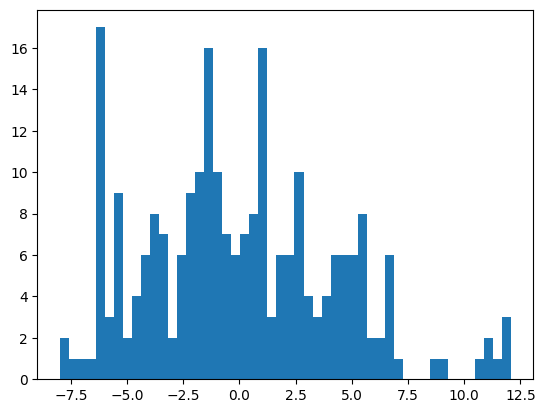

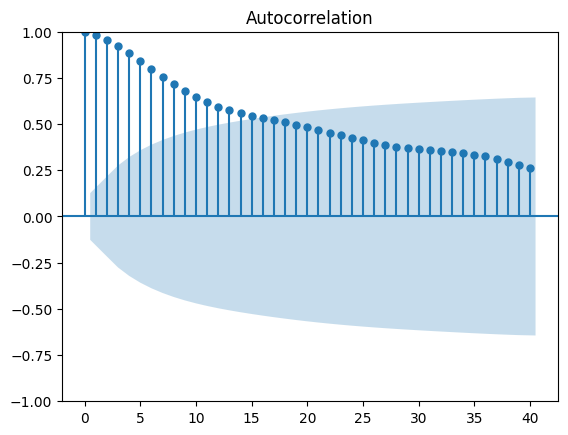

In [55]:
graficos.plotar_residuos(y_train, y_hat)

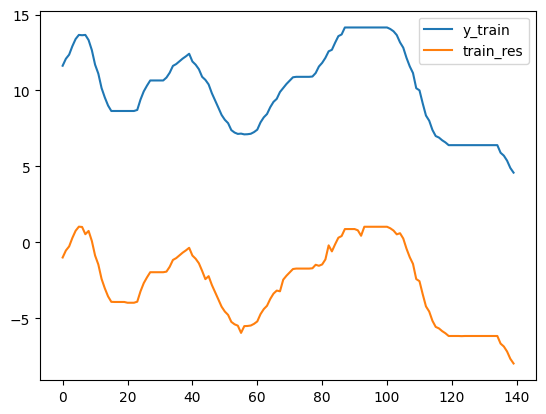

In [49]:
# plot residuals and training data
import matplotlib.pyplot as plt
plt.plot(y_train[100:500], label='y_train')
plt.plot(residuo[100:500], label='train_res')
plt.legend()
plt.show()